<a href="https://colab.research.google.com/github/chriswmann/keras-google-colab-tpu/blob/master/rr_l_stock_price_prediction_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Rolls-Royce Stock Price Prediction GRU.

Not a serious attempt at stock price prediction but a good problem to work on with an RNN nonetheless.

Very much a work in progress.

In [1]:
# imports
!pip install --upgrade pip
!pip install hyperopt
from keras.callbacks import CSVLogger, EarlyStopping, LambdaCallback, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Reshape
from keras.optimizers import SGD, Adam, Nadam
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
import keras.backend as K;
from keras.regularizers import L1L2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import datetime as dt
import re
from hyperopt import hp, fmin, tpe, hp, STATUS_FAIL, STATUS_OK, Trials
#from hyperopt.mongoexp import MongoTrials


# suppress future warnings for now
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Definitions
np.random.seed(39)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.use_inf_as_na = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
color = sns.color_palette()
sns.set()

# stuff to get data
from google.colab import drive
from google.colab import auth
drive.mount('/gdrive')
dir_path = '/gdrive/My Drive/Colab Notebooks/Stock Price Prediction/data'

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.1.1)


Using TensorFlow backend.


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
all_files = glob.glob(os.path.join(dir_path, '*.csv'))
stocks = []
fx = []
df_generator = (pd.read_csv(f, index_col='date') for f in stocks)
column_names = []
with open(os.path.join(dir_path, 'RR.L_stock_data_20180831.csv'), 'r') as f:
    columns = f.readline().split(',')[1:]
    start_index = f.readlines()[1].split(',')[0]

for f in all_files:
    if 'stock' in f:
        stocks.append(f)
        ticker = f.split('/')[-1].split('_')[0]
        for c in columns:
            column_names.append(re.sub(r'[\.|\s]+','_', f'{ticker}_{c}'))
    if 'fx' in f:
        fx.append(f)

fx_cols = '1. open,2. high,3. low,4. close'.split(',')
dfxs_ = []
for f in fx:
    df_ = pd.read_csv(f,index_col=None, dtype={'date':str})
    df_.set_index(pd.to_datetime(df_['date']), inplace=True)
    df_.sort_index(inplace=True)
    dfxs_.append(df_)
    ticker = f.split('/')[-1].split('daily_')[-1].split('.')[0]
    for c in fx_cols:
        column_names.append(re.sub(r'[\.|\s]+','_', f'{ticker}_{c}'))

df_fx = pd.concat(dfxs_, ignore_index=False, axis=1).drop(['date'], axis=1)
df_stocks = pd.concat(df_generator, ignore_index=False, axis=1)
df_stocks.index = pd.to_datetime(df_stocks.index)
df_fx.index = pd.to_datetime(df_fx.index)
start_fx = df_fx.index.searchsorted(dt.datetime(2000, 1, 3))
end_fx = df_fx.index.searchsorted(dt.datetime(2018, 8, 31))
start_stocks = df_stocks.index.searchsorted(dt.datetime(2000, 1, 3))
end_stocks = df_stocks.index.searchsorted(dt.datetime(2018, 8, 31))
df_stocks = df_stocks.iloc[start_stocks:end_stocks]
df_fx = df_fx.iloc[start_fx:end_fx]
df = pd.concat([df_fx, df_stocks], ignore_index=False, axis=1)
df.columns = column_names
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,RR_L_1_open,RR_L_2_high,RR_L_3_low,RR_L_4_close,RR_L_5_adjusted_close,RR_L_6_volume,RR_L_7_dividend_amount,RR_L_8_split_coefficient_,GE_1_open,GE_2_high,...,BA_L_7_dividend_amount,BA_L_8_split_coefficient_,GBP_USD_1_open,GBP_USD_2_high,GBP_USD_3_low,GBP_USD_4_close,EUR_USD_1_open,EUR_USD_2_high,EUR_USD_3_low,EUR_USD_4_close
2000-01-03,nan,nan,nan,nan,nan,nan,nan,nan,214.000,214.000,...,0.000,1.000,410.000,410.000,410.000,410.000,192.131,0.000,0.000,1.000
2000-01-04,nan,nan,nan,nan,nan,nan,nan,nan,223.000,235.000,...,0.000,1.000,415.000,420.000,404.000,408.500,191.428,12310650.000,0.000,1.000
2000-01-05,nan,nan,nan,nan,nan,nan,nan,nan,222.500,228.000,...,0.000,1.000,413.000,414.000,397.000,401.250,188.030,11922681.000,0.000,1.000
2000-01-06,nan,nan,nan,nan,nan,nan,nan,nan,226.800,226.800,...,0.000,1.000,402.000,410.000,396.000,404.750,189.671,11947304.000,0.000,1.000
2000-01-07,nan,nan,nan,nan,nan,nan,nan,nan,217.000,235.000,...,0.000,1.000,403.000,419.000,383.000,388.250,181.939,10992815.000,0.000,1.000


In [4]:
total_nans = df.isnull().sum(axis=1)[df.isnull().sum(axis=1) > 0].sum()
print(f'total_nans: {total_nans}')

total_nans: 14832


That's a lot of NaNs.

RR.L data (target) starts at 2000-01-03, so drop all rows before this date, which will remove a lot of NaNs.

In [5]:
print(df.shape)
start = df.index.searchsorted(dt.datetime(2000, 1, 3))
end = df.index.searchsorted(dt.datetime(2018, 8, 31))
df = df.iloc[start:end]
print(df.shape)

(5100, 48)
(5100, 48)


In [6]:
total_nans = df.isnull().sum(axis=1)[df.isnull().sum(axis=1) > 0].sum()
print(f'total_nans: {total_nans}')

total_nans: 14832


In [7]:
df.head()

,RR_L_1_open,RR_L_2_high,RR_L_3_low,RR_L_4_close,RR_L_5_adjusted_close,RR_L_6_volume,RR_L_7_dividend_amount,RR_L_8_split_coefficient_,GE_1_open,GE_2_high,...,BA_L_7_dividend_amount,BA_L_8_split_coefficient_,GBP_USD_1_open,GBP_USD_2_high,GBP_USD_3_low,GBP_USD_4_close,EUR_USD_1_open,EUR_USD_2_high,EUR_USD_3_low,EUR_USD_4_close
2000-01-03,nan,nan,nan,nan,nan,nan,nan,nan,214.000,214.000,...,0.000,1.000,410.000,410.000,410.000,410.000,192.131,0.000,0.000,1.000
2000-01-04,nan,nan,nan,nan,nan,nan,nan,nan,223.000,235.000,...,0.000,1.000,415.000,420.000,404.000,408.500,191.428,12310650.000,0.000,1.000
2000-01-05,nan,nan,nan,nan,nan,nan,nan,nan,222.500,228.000,...,0.000,1.000,413.000,414.000,397.000,401.250,188.030,11922681.000,0.000,1.000
2000-01-06,nan,nan,nan,nan,nan,nan,nan,nan,226.800,226.800,...,0.000,1.000,402.000,410.000,396.000,404.750,189.671,11947304.000,0.000,1.000
2000-01-07,nan,nan,nan,nan,nan,nan,nan,nan,217.000,235.000,...,0.000,1.000,403.000,419.000,383.000,388.250,181.939,10992815.000,0.000,1.000


In [0]:
df.fillna(df.rolling(7, min_periods=1).mean(), inplace=True)

In [0]:
df.fillna(df.median(), inplace=True)

In [0]:
moving_average_window = 7
df['RR_L_HL_Spread'] = df.RR_L_2_high - df.RR_L_3_low
df['RR_L_OC_Spread'] = df.RR_L_4_close - df.RR_L_1_open
df['RR_L_HL_MA_Spread'] = df.RR_L_HL_Spread - df.RR_L_HL_Spread.shift(moving_average_window)
df['RR_L_OC_MA_Spread'] = df.RR_L_OC_Spread - df.RR_L_OC_Spread.shift(moving_average_window)
# the moving average columns will create NaNs for the first n_moving_average_window rows
df.fillna(0, inplace=True)
df['RR_L_Close_UD'] = np.where(df['RR_L_OC_Spread']>=0, 1, 0)


In [11]:
df.describe()

,RR_L_1_open,RR_L_2_high,RR_L_3_low,RR_L_4_close,RR_L_5_adjusted_close,RR_L_6_volume,RR_L_7_dividend_amount,RR_L_8_split_coefficient_,GE_1_open,GE_2_high,...,GBP_USD_4_close,EUR_USD_1_open,EUR_USD_2_high,EUR_USD_3_low,EUR_USD_4_close,RR_L_HL_Spread,RR_L_OC_Spread,RR_L_HL_MA_Spread,RR_L_OC_MA_Spread,RR_L_Close_UD
count,5100.000,5100.000,5100.000,5100.000,5100.000,5100.000,5100.000,5100.000,5100.000,5100.000,...,5100.000,5100.000,5100.000,5100.000,5100.000,5100.000,5100.000,5100.000,5100.000,5100.000
mean,1.600,1.606,1.593,1.600,1.216,1.222,1.211,1.216,552.714,559.293,...,387.317,286.343,13225156.887,0.000,1.000,0.013,-0.000,-0.000,0.000,0.520
std,0.198,0.199,0.197,0.198,0.165,0.166,0.164,0.165,308.323,310.617,...,124.336,149.992,13259614.796,0.000,0.000,0.008,0.009,0.008,0.012,0.500
min,1.202,1.206,1.194,1.202,0.828,0.832,0.822,0.827,0.000,0.000,...,0.000,0.000,0.000,0.000,1.000,0.000,-0.121,-0.160,-0.122,0.000
25%,1.460,1.468,1.453,1.460,1.115,1.120,1.111,1.115,250.500,253.750,...,316.500,179.556,6905319.750,0.000,1.000,0.009,-0.004,-0.004,-0.007,0.000
50%,1.573,1.580,1.567,1.573,1.234,1.239,1.228,1.234,518.375,526.500,...,373.500,241.997,10088790.250,0.000,1.000,0.012,0.000,0.000,0.000,1.000
75%,1.715,1.723,1.711,1.715,1.334,1.339,1.328,1.334,825.763,834.650,...,465.762,378.487,15912849.000,0.000,1.000,0.016,0.005,0.004,0.007,1.000
max,2.107,2.116,2.097,2.107,1.600,1.603,1.587,1.600,1289.000,1294.000,...,677.000,676.400,497039744.000,0.000,1.000,0.166,0.046,0.141,0.124,1.000


In [0]:
X = df.drop('RR_L_4_close', axis=1)
y = df['RR_L_4_close']

In [13]:
X.shape

(5100, 52)

In [14]:
X.head()

,RR_L_1_open,RR_L_2_high,RR_L_3_low,RR_L_5_adjusted_close,RR_L_6_volume,RR_L_7_dividend_amount,RR_L_8_split_coefficient_,GE_1_open,GE_2_high,GE_3_low,...,GBP_USD_4_close,EUR_USD_1_open,EUR_USD_2_high,EUR_USD_3_low,EUR_USD_4_close,RR_L_HL_Spread,RR_L_OC_Spread,RR_L_HL_MA_Spread,RR_L_OC_MA_Spread,RR_L_Close_UD
2000-01-03,1.573,1.580,1.567,1.234,1.239,1.228,1.234,214.000,214.000,214.000,...,410.000,192.131,0.000,0.000,1.000,0.012,0.000,0.000,0.000,1
2000-01-04,1.573,1.580,1.567,1.234,1.239,1.228,1.234,223.000,235.000,221.000,...,408.500,191.428,12310650.000,0.000,1.000,0.012,0.000,0.000,0.000,1
2000-01-05,1.573,1.580,1.567,1.234,1.239,1.228,1.234,222.500,228.000,211.000,...,401.250,188.030,11922681.000,0.000,1.000,0.012,0.000,0.000,0.000,1
2000-01-06,1.573,1.580,1.567,1.234,1.239,1.228,1.234,226.800,226.800,215.000,...,404.750,189.671,11947304.000,0.000,1.000,0.012,0.000,0.000,0.000,1
2000-01-07,1.573,1.580,1.567,1.234,1.239,1.228,1.234,217.000,235.000,217.000,...,388.250,181.939,10992815.000,0.000,1.000,0.012,0.000,0.000,0.000,1


In [0]:
X = X.values.astype('float64')
y = y.values

In [0]:
X_train_, X_val, y_train_, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(
    X_train_, y_train_, test_size=0.3, random_state=42, shuffle=False)

In [0]:
scale = MinMaxScaler([-0.2, 0.2])
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)
X_val = scale.transform(X_val)

In [18]:
for data in [('X_train', X_train), ('X_test', X_test), ('X_val', X_val)]:
    assert not np.any(np.isnan(data[1]))
    print(f"{data[0]:7} max: {data[1].max(): .3f}")
    print(f"{data[0]:7} min: {data[1].min(): .3f}")

X_train max:  0.200
X_train min: -0.200
X_test  max:  0.882
X_test  min: -0.254
X_val   max:  0.936
X_val   min: -0.536


In [0]:
n_days_lag = 7
n_batch_size = 64

In [0]:
def reshape_input(X, y=None, n_days_lag=0):
    """
    Reshape training data (including DV) to lag the IVs and create batches.
    Args:
        X (independent variables)
        y (dependent variable/target)
    Returns:
        X_train of shape (n_batches, n_batch_size, n_features)
        y_train
        n_features
        X_shape (X_train shape)
    """
    
    n_features = X.shape[-1]
    n_useful_samples = X.shape[0] - n_days_lag
    n_batches = int(n_useful_samples / n_batch_size)
    X_useful_range = np.array(range(n_batch_size * n_batches))
    X = X.take([X_useful_range], axis=0)
    X_shape = (n_batches, n_batch_size, n_features)
    X = np.reshape(X, X_shape)
    try:
        y_useful_range = X_useful_range + n_days_lag
        y = y.take([y_useful_range], axis=0)
        y = y.T[1::n_batch_size]
    
        return X, y, n_features, X_shape
    except AttributeError:
        return X, n_features, X_shape

In [0]:
X_train, y_train, n_features, X_shape = reshape_input(X_train, y_train, n_days_lag=n_days_lag)
X_test, y_test, n_features, X_shape = reshape_input(X_test, y_test, n_days_lag=n_days_lag)
X_val, y_val, n_features, X_val_shape = reshape_input(X_val, y_val, n_days_lag=0)

In [0]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [0]:
# define custom loss function to use RMSE in the NN model
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [0]:
# define callbacks
## print epoch number to show progress with less output than verbose offers
epoch_print_callback = LambdaCallback(
    on_epoch_begin=lambda epoch,
    logs: print(f'Epoch: {epoch + 1}/{n_epochs}\tTime: {dt.datetime.now().time().strftime("%H:%M:%S")}') if epoch%10 == 0 else False)

## logging
now = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
csv_logger = CSVLogger(f'gru_log_draft_{now}.csv', append=True, separator=',')

## learning rate reduction at plateua in loss
patience = 10
rlrop = ReduceLROnPlateau(monitor='loss',
                         factor=0.1,
                         patience=patience,
                         verbose=1,
                         mode='min',
                         min_delta=0.01,
                         cooldown=0,
                         min_lr=1e-6)

## early stopping
early_stop = EarlyStopping(monitor='loss',
                           min_delta=0.0001,
                           patience=patience * 2,
                           verbose=1,
                           mode='min')

In [25]:
# hyperparameters
## architecture

input_shape = X_train.shape[1:]
n_units = 64
dropout_rate = 0.5
depth = 2
## training
n_epochs = 200
val_split = 0.2
if n_epochs < 1e3:
    verbose = 1
else:
    verbose = 0
    callbacks = [epoch_print_callback]
verbose = 0
callbacks = [rlrop, early_stop]
## optimisation
lr = 0.01
momentum = 0.01
decay = 0.0
nesterov = False
sgd = SGD(lr=lr, momentum=momentum, decay=decay, nesterov=nesterov)
adam = Adam(lr=lr, decay=decay)
optimiser = adam

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
space = {'hypersearch': hp.choice('hypersearch', [True]),
         'n_units': hp.pchoice('n_units', [(0.3, 4), (0.4, 8), (0.3, 16)]),
         'depth': hp.pchoice('depth', [(0.4, 4), (0.3, 8), (0.3, 16)]),
         'dropout_rate': hp.uniform('dropout_rate',0.4,0.9),
         'optimiser': hp.choice('optimiser',
                                 ['adadelta',
                                  'rmsprop',
                                  'adam',
                                  'sgd']),
         'activation': hp.pchoice('activation', [(0.1, 'tanh'),
                                                 (0.3, 'relu'),
                                                 (0.15, 'sigmoid'),
                                                 (0.3, 'elu'),
                                                 (0.15, 'softmax')]),
         'recurrent_activation': hp.pchoice('recurrent_activation',[(0.1, 'softmax'),
                                                                    (0.3, 'relu'),
                                                                    (0.15, 'sigmoid'),
                                                                    (0.3, 'elu'),
                                                                    (0.15, 'hard_sigmoid')]),
         'regulariser': hp.choice('regulariser', [{'l1': 0.0000, 'l2': 0.0001},
                                                  {'l1': 0.0001, 'l2': 0.0000},
                                                  {'l1': 0.0001, 'l2': 0.0001}])}

In [0]:
# tune hyperparameters with hyperopt
def gru(params):
    print (f'Params testing: {params}')
    model = Sequential()
    model.add(GRU(params['n_units'],
                  input_shape=input_shape,
                  activation=params['activation'],
                  recurrent_activation=params['recurrent_activation'],
                  kernel_regularizer=L1L2(l1=params['regulariser']['l1'],
                                          l2=params['regulariser']['l2'])))
    for i in range(depth):
        model.add(Dropout(rate=params['dropout_rate']))
        model.add(Reshape((-1, params['n_units'])))
        model.add(GRU(n_units,
                      activation=params['activation'],
                      recurrent_activation=params['recurrent_activation'],
                      kernel_regularizer=L1L2(l1=params['regulariser']['l1'],
                                              l2=params['regulariser']['l2'])))
    model.add(Dense(1, name='price'))
    model.compile(loss=rmse,
                  optimizer=params['optimiser'],
                 )

    model.fit(X_train,
              y_train,
              validation_split=val_split,
              shuffle=False,
              epochs=n_epochs,
              callbacks=callbacks,
              verbose=verbose)

    y_pred = model.predict(X_test)
    loss = np.sqrt(mse(y_test, y_pred))
    print(f'loss: {loss}')
    try:
        params['hypersearch']
        if loss > np.finfo(np.float32).max:
            return {'status': STATUS_FAIL, 'model': model}
        else:
            return {'loss': loss, 'status': STATUS_OK, 'model': model}
    except KeyError:
        return model
        

### Run Trials

In [28]:
trials = Trials()
best = fmin(gru, space, algo=tpe.suggest, max_evals=10, trials=trials)

Params testing: {'activation': 'sigmoid', 'depth': 16, 'dropout_rate': 0.8076078059307501, 'hypersearch': True, 'n_units': 16, 'optimiser': 'adam', 'recurrent_activation': 'elu', 'regulariser': {'l1': 0.0001, 'l2': 0.0001}}
  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00053: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00062: early stopping
loss: 0.10225101215329062
Params testing: {'activation': 're

In [29]:
from hyperopt import space_eval
best_params = space_eval(space, best)
best_params.pop('hypersearch')
best_params

{'activation': 'elu',
 'depth': 16,
 'dropout_rate': 0.7357143557667535,
 'n_units': 8,
 'optimiser': 'rmsprop',
 'recurrent_activation': 'relu',
 'regulariser': {'l1': 0.0001, 'l2': 0.0001}}

In [32]:
model = gru(best_params)

Params testing: {'activation': 'elu', 'depth': 16, 'dropout_rate': 0.7357143557667535, 'n_units': 8, 'optimiser': 'rmsprop', 'recurrent_activation': 'relu', 'regulariser': {'l1': 0.0001, 'l2': 0.0001}}

Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00107: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00117: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00125: early stopping
loss: 0.07468421602527074


In [33]:
train_history = model.fit(X_train, y_train,
                          shuffle=False,
                          epochs=n_epochs,
                          callbacks=callbacks,
                          verbose=1)

Epoch 1/200
38/38 [==============================] - 0s 4ms/step - loss: 0.2147
Epoch 2/200
38/38 [==============================] - 0s 4ms/step - loss: 0.1936
Epoch 3/200
38/38 [==============================] - 0s 4ms/step - loss: 0.2344
Epoch 4/200
38/38 [==============================] - 0s 4ms/step - loss: 0.2239
Epoch 5/200
38/38 [==============================] - 0s 4ms/step - loss: 0.2283
Epoch 6/200
38/38 [==============================] - 0s 4ms/step - loss: 0.2007
Epoch 7/200
38/38 [==============================] - 0s 4ms/step - loss: 0.2177
Epoch 8/200
38/38 [==============================] - 0s 4ms/step - loss: 0.2231
Epoch 9/200
38/38 [==============================] - 0s 4ms/step - loss: 0.2169
Epoch 10/200
38/38 [==============================] - 0s 4ms/step - loss: 0.2233
Epoch 11/200
38/38 [==============================] - 0s 4ms/step - loss: 0.2207
Epoch 12/200
38/38 [==============================] - 0s 4ms/step - loss: 0.2173

Epoch 00012: ReduceLROnPlateau reduc

In [0]:
def plot_history(history):
    for hist_key in history.history.keys():
        plt.plot(history.history[hist_key])
        plt.title(f'model {hist_key}')
        plt.ylabel(f'{hist_key}')
        plt.xlabel('epoch')
        plt.legend([k for k in history.history.keys()], loc='upper left')
        plt.show()

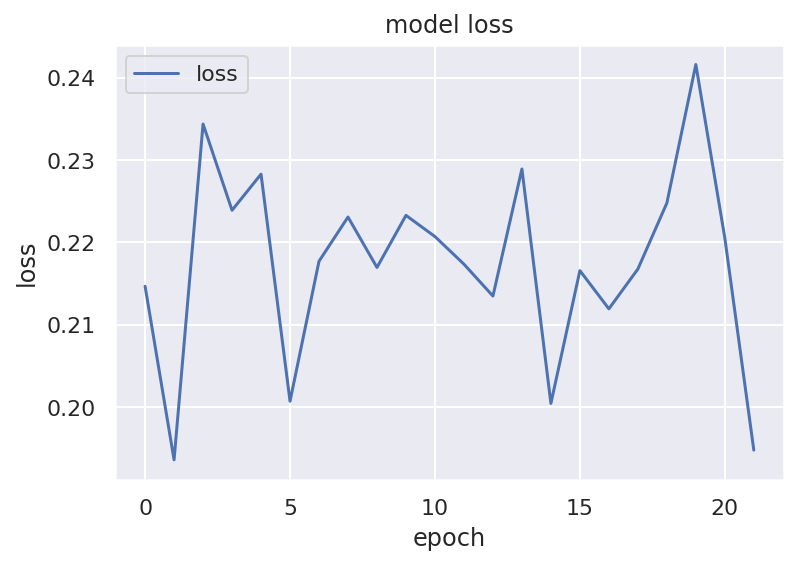

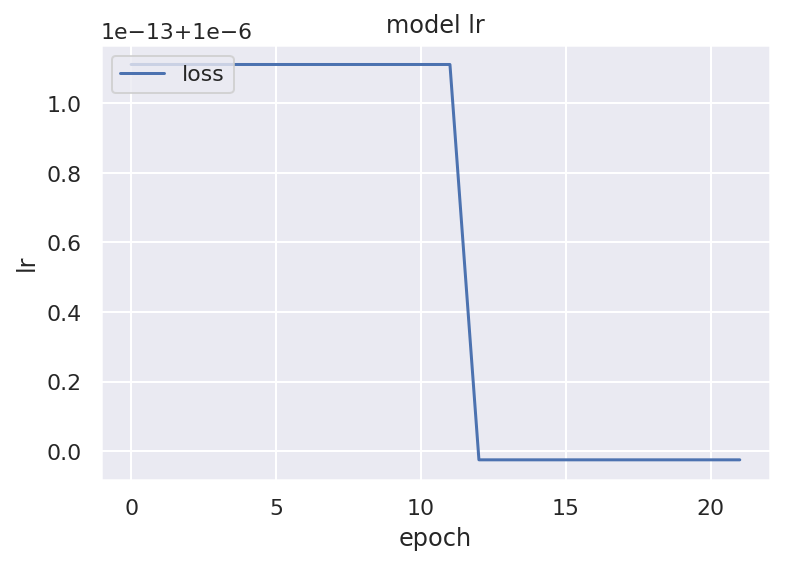

In [35]:
plot_history(train_history)

In [0]:
y_pred = model.predict(X_val)

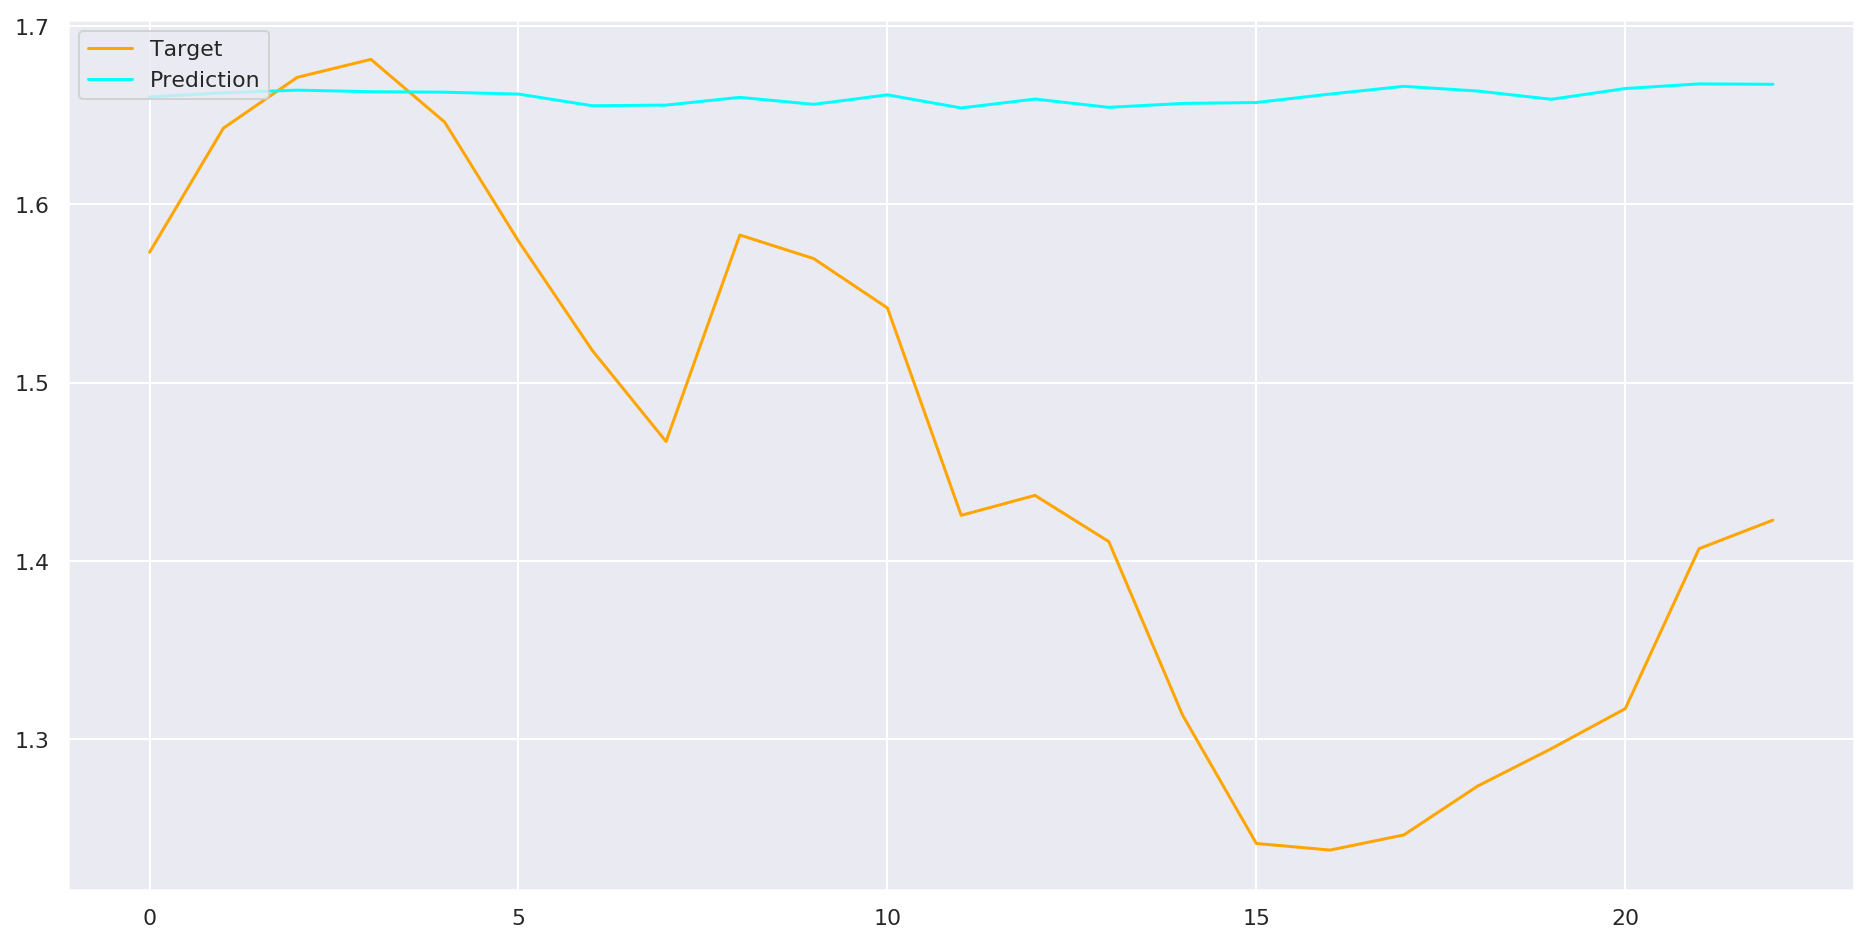

In [37]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
x = range(len(y_pred))
ax.plot(x, y_val, c='orange', label='Target')
ax.plot(x, y_pred, c='cyan', label='Prediction')
plt.legend(loc='upper left');
plt.show()

In [38]:
np.sqrt(mse(y_val, y_pred))

0.2500248711552198